23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:46 - cmdstanpy - INFO - Chain [1] done processing


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:47 - cmdstanpy - INFO - Chain [1] done processing
23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:47 - cmdstanpy - INFO - Chain [1] done processing
23:19:47 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing


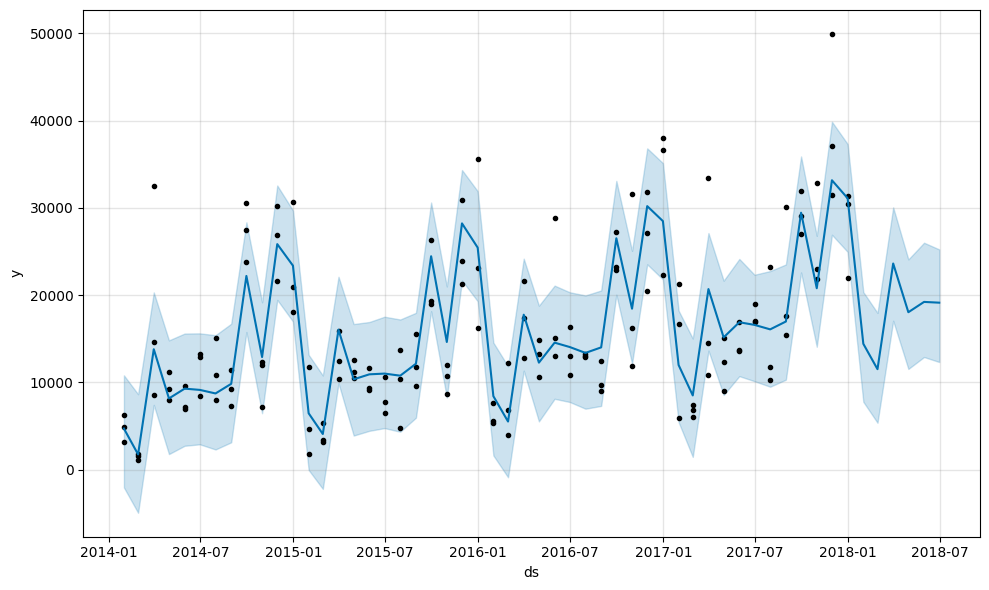

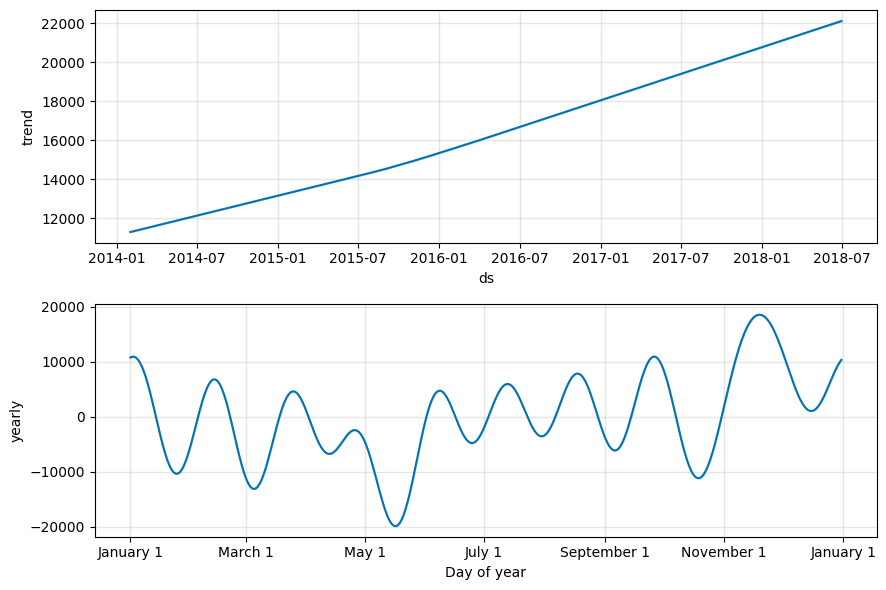

In [31]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt 
from prophet import Prophet
def read_encoding(file_path):
    with open(file_path,'rb') as f:
        raw_data = f.read() 
        detect_data = chardet.detect(raw_data)
        encoding = detect_data['encoding'] 
        df = pd.read_csv(file_path, encoding = encoding)
        return df 
df = read_encoding('superstore.csv') 
print(df.head()) 
df['Order Date'] = pd.to_datetime(df['Order Date']) 
monthly = ( 
    df.set_index('Order Date').groupby('Category').resample('ME')['Sales'].sum().reset_index() 
) 
# For prophet
data = monthly[['Order Date','Sales']].copy()
data.columns = ['ds', 'y'] 
model = Prophet() 
model.fit(data) 
future = model.make_future_dataframe(periods = 6, freq = 'ME') 
forecast = model.predict(future) 
fig = model.plot(forecast) 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast.csv', index=False)
model.plot_components(forecast) 
combined = data.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='outer') 
monthly.columns = ['Category', 'ds', 'y']

# Ensure ds is datetime
monthly['ds'] = pd.to_datetime(monthly['ds'], errors='coerce')
monthly = monthly.dropna(subset=['ds'])  # remove rows with invalid dates

# --- Forecast per category ---
forecasts = []

for cat in monthly['Category'].unique():
    cat_data = monthly[monthly['Category'] == cat][['ds','y']].copy()
    
    model_cat = Prophet()
    model_cat.fit(cat_data)
    
    future_cat = model_cat.make_future_dataframe(periods=6, freq='ME')
    forecast_cat = model_cat.predict(future_cat)
    
    # Add category column
    forecast_cat['Category'] = cat
    
    # Keep only relevant columns
    forecasts.append(forecast_cat[['ds','yhat','yhat_lower','yhat_upper','Category']])

# Combine all forecasts
forecast_all = pd.concat(forecasts)

# --- Merge forecasts with actual sales ---
combined = monthly.merge(
    forecast_all,
    on=['ds','Category'],  # merge on both date and category
    how='outer'
)
# Reorder columns: ds, Category, y, yhat, yhat_lower, yhat_upper
combined = combined[['ds', 'Category', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]
combined.to_csv('sales_forecast_output.csv', index=False)

21:11:27 - cmdstanpy - INFO - Chain [1] start processing


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

21:11:27 - cmdstanpy - INFO - Chain [1] done processing


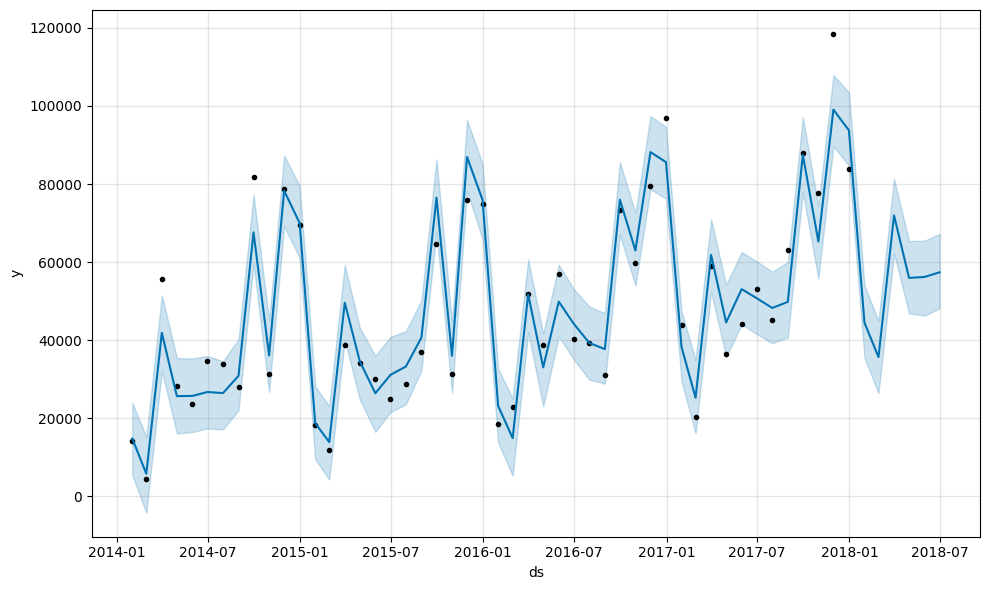

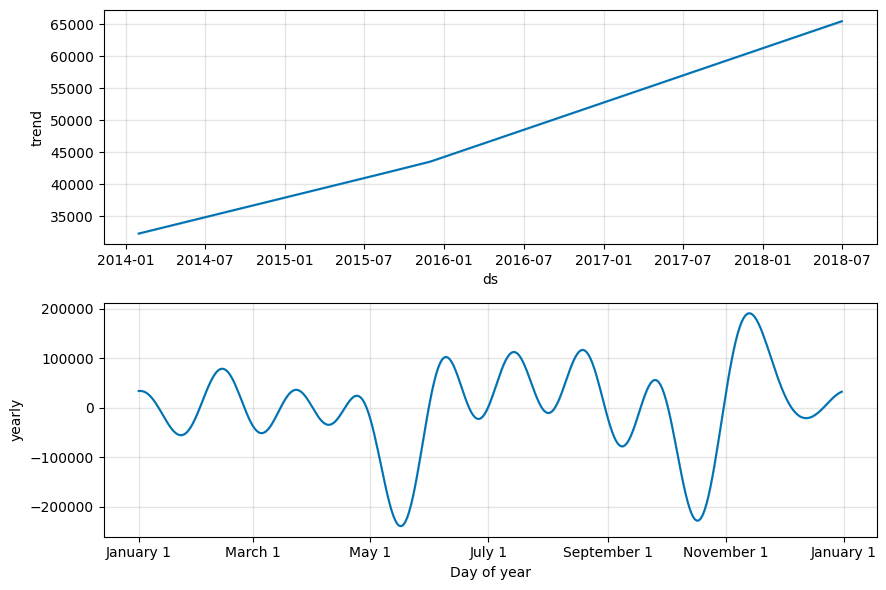

In [9]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from prophet import Prophet

# --- Function to read CSV with detected encoding ---
def read_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        detect_data = chardet.detect(raw_data)
        encoding = detect_data['encoding']
        df = pd.read_csv(file_path, encoding=encoding)
    return df

# --- Read the dataset ---
df = read_encoding('superstore.csv')
print(df.head())

# --- Prepare Order Date column ---
df['Order Date'] = pd.to_datetime(df['Order Date'])

# --- Aggregate monthly sales ---
monthly = (
    df.set_index('Order Date')
      .resample('ME')['Sales']
      .sum()
      .reset_index()
)

# --- Prepare data for Prophet ---
data = monthly.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# --- Build and fit Prophet model ---
model = Prophet()
model.fit(data)

# --- Create future periods for forecasting ---
future = model.make_future_dataframe(periods=6, freq='ME')

# --- Predict future values ---
forecast = model.predict(future)

# --- Plot forecast ---
fig = model.plot(forecast)
model.plot_components(forecast)

# --- Combine forecast results with original data ---
combined = data.merge(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='outer'
)

# --- Now add the other columns (not forecasted) ---
# We just join them by the closest month so they appear in the CSV
df['Order Month'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()
combined['Order Month'] = combined['ds'].dt.to_period('M').dt.to_timestamp()

final = pd.merge(
    df,
    combined[['Order Month', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='Order Month',
    how='left'
)

# --- Select columns you want in final file ---
columns_to_keep = [
    'Order Date', 'Ship Mode', 'Segment', 'State', 'Region', 'Category',
    'Sub-Category', 'Quantity', 'Discount', 'Profit', 'Sales',
    'yhat', 'yhat_lower', 'yhat_upper'
]

final = final[[col for col in columns_to_keep if col in final.columns]]

# --- Save final CSV safely ---
final.to_csv('sales_forecast.csv', index=False)

In [ ]:
import pandas as pd
import chardet
from prophet import Prophet
import warnings

# --- Suppress FutureWarnings from pandas ---
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Function to read CSV with detected encoding ---
def read_encoding(file_path):
    with open(file_path,'rb') as f:
        raw_data = f.read()
        encoding = chardet.detect(raw_data)['encoding']
        df = pd.read_csv(file_path, encoding=encoding)
    return df

# --- Read dataset ---
df = read_encoding('superstore.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'])

# --- Aggregate actual sales daily ---
daily_actuals = df.groupby('Order Date').agg({'Sales':'sum'}).reset_index()
daily_actuals.rename(columns={'Order Date':'ds','Sales':'y'}, inplace=True)

# --- Fit Prophet model ---
model = Prophet()
model.fit(daily_actuals[['ds','y']])

# --- Forecast next 15 days ---
future = model.make_future_dataframe(periods=15, freq='D')
forecast = model.predict(future)

# --- Keep only future forecast rows ---
forecast_future = forecast[forecast['ds'] > daily_actuals['ds'].max()][['ds','yhat','yhat_lower','yhat_upper']]
forecast_future.rename(columns={'ds':'Order Date'}, inplace=True)

# --- Add missing columns for consistency with original dataset ---
for col in df.columns:
    if col not in forecast_future.columns:
        forecast_future[col] = None
forecast_future['Sales'] = None  # actual sales unknown for future

# --- Concatenate historical and future forecast safely ---
final = pd.concat([df, forecast_future], ignore_index=True)

# --- Reorder columns (optional) ---
columns_order = [
    'Order Date', 'Ship Mode', 'Segment', 'State', 'Region', 'Category',
    'Sub-Category', 'Quantity', 'Discount', 'Profit', 'Sales',
    'yhat', 'yhat_lower', 'yhat_upper'
]
final = final[[col for col in columns_order if col in final.columns]]

# --- Save final merged CSV ---
final.to_csv('sales_forecast.csv', index=False)

23:12:47 - cmdstanpy - INFO - Chain [1] start processing
23:12:47 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
import pandas as pd
import chardet

# Load dataset
def read_encoding(file_path):
    with open(file_path,'rb') as f:
        raw_data = f.read() 
        detect_data = chardet.detect(raw_data)
        encoding = detect_data['encoding'] 
        df = pd.read_csv(file_path, encoding = encoding)
        return df 
df = read_encoding('superstore.csv') 

# Check for missing values and data types
print(df.info())
print(df.isnull().sum())

# Fill missing values or drop rows
df = df.dropna(subset=['Order Date', 'Sales'])  # Adjust columns as needed

# Convert date column
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Aggregate sales monthly
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME')).agg({'Sales':'sum'}).reset_index()
monthly_sales.rename(columns={'Order Date':'ds', 'Sales':'y'}, inplace=True)
# Prophet needs columns 'ds' (datetime) and 'y' (target variable)

print(monthly_sales.head())
from prophet import Prophet

# Instantiate and fit the model
model = Prophet()
model.fit(monthly_sales)

# Forecast next 12 months
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

fig = model.plot(forecast)
model.plot_components(forecast)

# View forecasts
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

# Export forecast to CSV for Power BI
export_df = forecast[['ds', 'yhat']]
export_df.rename(columns={'ds': 'Month', 'yhat': 'Forecasted Sales'}, inplace=True)
export_df.to_csv('superstore_forecast.csv', index=False)
# Region or category-based monthly sales for dashboard slicing
region_sales = df.groupby([pd.Grouper(key='Order Date', freq='ME'), 'Region'])['Sales'].sum().reset_index()
region_sales.rename(columns={'Order Date':'Month', 'Sales':'Region Sales'}, inplace=True)
region_sales.to_csv('region_sales_by_month.csv', index=False)

# Top items (for insight cards)
top_items = df.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).reset_index()
top_items.to_csv('top_items.csv', index=False)